In [43]:
import numpy as np
import random

class neru_bp():
    def __init__(self, learning_rate = .2,mini_batch_size=1,archtecture=[1,2,1], n_iterations = 3000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.bp_gredient=[]
        self.train_weights=[];     #  训练权重
        self.train_weights_grad=[];#  权重梯度
        self.train_bias=[];        #  训练偏置
        self.train_bias_grad=[];   #  偏置梯度
        self.feedforward_a=[];     #  前向传播得到的激活值的中间输出
        self.error_term=[];        #  残差
        self.w_gredient=[];
        self.predict_a=[];         #  预测中间值, 用于单个样本的预测输出
        self.train_labels=[]#1Xmini_batch_size
        #self.learning_rate;                           #  反向传播学习率
        self.lambda1=0.0  
        self.losses = []#  过拟合参数
        self.mini_batch_size=mini_batch_size;                            #  批量梯度下降的一个批次数量
        self.iteration_size=n_iterations;                             #  迭代次数
        self.architecture=archtecture;                  # 神经网络的结构（4， 4, 1） 表示有一个input layer(4个神经元, 和输入数据的维度一致), 
    def init_value(self):
        for i in range(len(self.architecture)):
            if i>=1:
                w=np.random.rand(self.architecture[i],self.architecture[i-1])*0.01
                self.train_weights.append(w)
                wg=np.zeros([self.architecture[i],self.architecture[i-1]])
                self.train_weights_grad.append(wg)
                b=np.random.rand(self.architecture[i],1)
                self.train_bias.append(b)
                bg=np.zeros([self.architecture[i],1])
                self.train_bias_grad.append(bg)
                a=np.zeros([self.architecture[i],self.mini_batch_size])
                self.feedforward_a.append(a)#这个和bais,bais_gredient以及下面的变量都是从第二层才开始有的！！！！！
                e=np.zeros([self.architecture[i],self.mini_batch_size])
                self.error_term.append(e)
                self.bp_gredient.append(e)
                pa=np.zeros([self.architecture[i],1])
                self.predict_a.append(pa)
    def get_batch_bias(self,bias):
        n=bias.shape[0]
        res_bias=np.zeros([n,self.mini_batch_size])
        for i in range(self.mini_batch_size):
            res_bias[:,i]=bias.reshape(n,)
        return res_bias
    
    def tanh(self,x):
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def feedforward(self,X):#不包括输入层的x
        for i in range(len(self.feedforward_a)):
            
            #print(i)
            if i==0:
                
                z=np.dot(self.train_weights[i],X)+self.get_batch_bias(self.train_bias[i])
                z=z.reshape(z.shape[0],self.mini_batch_size)
                
                self.feedforward_a[i]=self.tanh(z)
            
            elif i< len(self.feedforward_a)-1 and i >0:
                self.feedforward_a[i]=self.tanh(np.dot(self.train_weights[i],self.feedforward_a[i-1])+self.get_batch_bias(self.train_bias[i]))
       
               
            else:
                self.feedforward_a[i]=self.sigmoid(np.dot(self.train_weights[i],self.feedforward_a[i-1])+self.get_batch_bias(self.train_bias[i]))
       
        return self.feedforward_a
    
    def sig_bg(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    
    def tan_bg(self,x):
        return 1- self.tanh(x)*self.tanh(x)
    
    def back_forward(self,X,train_labels):
        train_labels=train_labels.reshape(train_labels.shape[0],self.mini_batch_size)
        X=X.reshape(X.shape[0],self.mini_batch_size)
        
        bp_gredient=[]
        bk_len=list(range(len(self.architecture)))
        bk_len.reverse()
        bk_len.pop()#第一层是x，不是z，
        self.feedforward(X)
        for i in bk_len:
            
            if i==len(self.architecture)-1:
                
                #er1=-(self.feedforward_a[i-1]-train_labels)*self.sig_bg(np.dot(self.train_weights[i-1],self.feedforward_a[i-2]))
                er1=-(-self.feedforward_a[i-1]+train_labels)*self.sig_bg(self.feedforward_a[i-1])
               
                #self.bp_gredient.append(er1)
                self.bp_gredient[i-1]=er1
                #bp_mean=np.mean(self.bp_gredient[i-1],axis=1)
                w_g=np.dot(self.bp_gredient[i-1],self.feedforward_a[i-2].T)/self.mini_batch_size
                b_g=np.mean(self.bp_gredient[i-1],axis=1)
#                 self.train_weights_grad.append(w_g)
#                 self.train_bias_grad.append(b_g)
                b_g=np.reshape(b_g,newshape=self.train_bias_grad[i-1].shape)#!!!!!!!!
                self.train_weights_grad[i-1]=w_g
                self.train_bias_grad[i-1]=b_g
            elif i==1:
                
                #print(self.bp_gredient[i-1].T)
                #er1=(np.dot(self.bp_gredient[i].T,self.train_weights[i])).T*self.sig_bg(np.dot(self.train_weights[i-1],X))
                er1=(np.dot(self.bp_gredient[i].T,self.train_weights[i])).T*self.tan_bg(self.feedforward_a[i-1])
                self.bp_gredient[i-1]=er1
                bp_mean=np.mean(self.bp_gredient[i-1],axis=1)
                w_g=np.dot(self.bp_gredient[i-1],X.T)/self.mini_batch_size
                b_g=np.mean(self.bp_gredient[i-1],axis=1)
#                 self.train_weights_grad.append(w_g)
#                 self.train_bias_grad.append(b_g)
                self.train_weights_grad[i-1]=w_g
                b_g=np.reshape(b_g,newshape=self.train_bias_grad[i-1].shape)#!!!!!!!!
                self.train_bias_grad[i-1]=b_g
            else:
                #er1=(np.dot(self.bp_gredient[i].T,self.train_weights[i])).T*self.sig_bg(np.dot(self.train_weights[i-1],self.feedforward_a[i-2]))
                er1=(np.dot(self.bp_gredient[i].T,self.train_weights[i])).T*self.tan_bg(self.feedforward_a[i-1])
                self.bp_gredient[i-1]=er1
                w_g=np.dot(self.bp_gredient[i-1],self.feedforward_a[i-2].T)/self.mini_batch_size
#                 self.train_weights_grad.append(w_g)
#                 self.train_bias_grad.append(b_g)
                b_g=np.mean(self.bp_gredient[i-1],axis=1)
                b_g=np.reshape(b_g,newshape=self.train_bias_grad[i-1].shape)
                self.train_weights_grad[i-1]=w_g
                self.train_bias_grad[i-1]=b_g
            
        #self.bp_gredient.clear()
    def get_minibatch(self,X,y):
        m=X.shape[1]
        list1=list(range(m))
        sample_num=random.sample(list1,self.mini_batch_size)
        #sample_num=np.random.randint(m)
        #print("sample is:",sample_num)
        return X[:,sample_num],y[:,sample_num]
    def predict(self,X):#对单个样本预测
#         print(X.shape)
        n,m=X.shape[0],X.shape[1]
        X=X.reshape([n,m])
        for i in range(len(self.predict_a)):
            if i==0:
                #print(np.dot(self.train_weights[i],X))
                z=np.dot(self.train_weights[i],X)+self.train_bias[i]
                #print(self.train_bias[i])
                self.predict_a[i]=self.tanh(z)
            elif i< len(self.predict_a)-1:
                self.predict_a[i]=self.tanh(np.dot(self.train_weights[i],self.predict_a[i-1])+self.train_bias[i])
            else:
                self.predict_a[i]=self.sigmoid(np.dot(self.train_weights[i],self.predict_a[i-1])+self.train_bias[i])
        return self.predict_a[len(self.predict_a)-1]
        
    def loss(self,X,y,pred_y):
        m=y.shape[1]
        loss_squre=0
        loss_regular=0
        for i in range(m):
            loss_squre+=np.dot((y[:,i]-pred_y[:,i]).T,(y[:,i]-pred_y[:,i]))
#         loss_squre = np.sum()
        loss_squre=loss_squre/m
#         print(loss_squre.shape)
        
        for j in range(len(self.train_weights)):
            temp_w=self.train_weights[j]
            loss_regular+=np.sum(temp_w*temp_w)
        loss_regular*=self.lambda1/2
        return loss_squre+loss_regular
    def evaluate(self,test_X,test_y,onehot):
#         print(test_X.shape)
        cnt=0
        for i in range(test_X.shape[1]):
            pred_y=self.predict(test_X[:,i].reshape([test_X[:,i].shape[0],1]))
#             print(pred_y)
#             print(test_y)
            #print("pred_y",pred_y)
            #print("真实结果与预测结果",np.argmax(test_y[:,i],axis=0),np.argmax(pred_y,axis=0)[0])
            if(onehot):
                if np.argmax(test_y[:,i],axis=0)==np.argmax(pred_y,axis=0)[0]:
                    #print('argmax:',np.argmax(test_y[:,i],axis=0))
                    #print("真实结果与预测结果",np.argmax(test_y[:,i],axis=0),np.argmax(pred_y,axis=0)[0])
                    cnt+=1
            else:
                if(pred_y[0,0]==test_y[0,i]):
                    cnt+=1
        print("预测准确率为：%f"%(cnt/test_y.shape[1]*100),"%")
        return cnt/test_y.shape[1]
                      
    def train(self,X,y):
        for i in range(self.iteration_size):
            X_batch,y_batch=self.get_minibatch(X,y)
            pred_y=self.predict(X_batch)
            loss = self.loss(X_batch,y_batch,pred_y)
            self.losses.append(loss)
            self.back_forward(X_batch,y_batch)
            for j in range(len(self.train_weights)):
                self.train_weights[j]=self.train_weights[j]-self.learning_rate*(self.train_weights_grad[j]+self.lambda1*self.train_weights[j])
                self.train_bias[j]-=self.learning_rate*self.train_bias_grad[j]
        #for i in range(len(self.train_weights)):
            #print("train_weights %d"%i)
            #print(self.train_weights[i])
            #print("train_bias %d"%i)
            #print(self.train_bias[i])

In [18]:
import pandas as pd
data = pd.read_csv('1_data.txt',sep=' ',header=None)

In [19]:
data_np = np.array(data)
x = data_np[:,0:3]
y = data_np[:,3]
y = y.reshape((30,1))
from sklearn.preprocessing import LabelBinarizer
y2=LabelBinarizer().fit_transform(y)
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y2)

In [148]:
bp_neru=neru_bp(learning_rate=0.2,mini_batch_size=1,n_iterations=3000,archtecture=[3,3,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

(3, 8)
预测准确率为：62.500000 %


0.625

In [153]:
bp_neru=neru_bp(learning_rate=0.2,mini_batch_size=1,n_iterations=3000,archtecture=[3,4,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

(3, 8)
预测准确率为：75.000000 %


0.75

In [150]:
bp_neru=neru_bp(learning_rate=0.2,mini_batch_size=1,n_iterations=3000,archtecture=[3,10,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

(3, 8)
预测准确率为：75.000000 %


0.75

In [151]:
bp_neru=neru_bp(learning_rate=0.2,mini_batch_size=1,n_iterations=3000,archtecture=[3,20,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

(3, 8)
预测准确率为：62.500000 %


0.625

In [154]:
bp_neru=neru_bp(learning_rate=0.01,mini_batch_size=1,n_iterations=3000,archtecture=[3,10,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

(3, 8)
预测准确率为：50.000000 %


0.5

In [155]:
bp_neru=neru_bp(learning_rate=0.1,mini_batch_size=1,n_iterations=3000,archtecture=[3,10,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

(3, 8)
预测准确率为：50.000000 %


0.5

In [162]:
bp_neru=neru_bp(learning_rate=0.2,mini_batch_size=1,n_iterations=3000,archtecture=[3,10,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

(3, 8)
预测准确率为：87.500000 %


0.875

In [20]:
bp_neru=neru_bp(learning_rate=0.2,mini_batch_size=1,n_iterations=100000,archtecture=[3,10,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

(3, 8)
预测准确率为：75.000000 %


0.75

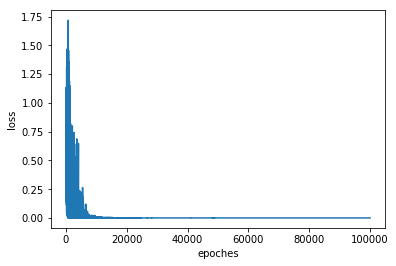

In [22]:
losses = np.array(bp_neru.losses)
losses = losses.reshape((100000,1))
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)),losses)
plt.xlabel('epoches')
plt.ylabel('loss')
plt.show()

In [45]:
bp_neru=neru_bp(learning_rate=0.2,mini_batch_size=4,n_iterations=3000,archtecture=[3,10,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

预测准确率为：75.000000 %


0.75

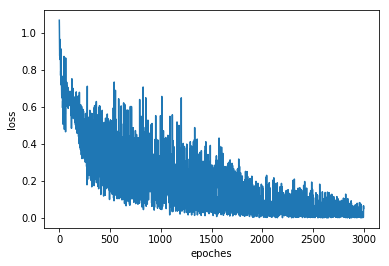

In [46]:
losses = np.array(bp_neru.losses)
losses = losses.reshape((3000,1))
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)),losses)
plt.xlabel('epoches')
plt.ylabel('loss')
plt.show()

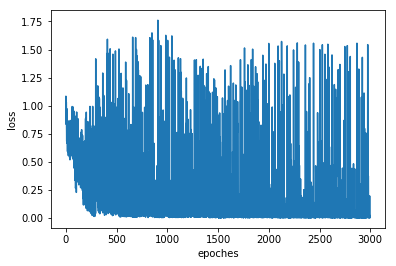

In [163]:
losses = np.array(bp_neru.losses)
losses = losses.reshape((3000,1))
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)),losses)
plt.xlabel('epoches')
plt.ylabel('loss')
plt.show()

In [161]:
bp_neru=neru_bp(learning_rate=0.4,mini_batch_size=1,n_iterations=3000,archtecture=[3,10,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

(3, 8)
预测准确率为：62.500000 %


0.625

In [158]:
bp_neru=neru_bp(learning_rate=0.5,mini_batch_size=1,n_iterations=3000,archtecture=[3,10,3])
bp_neru.init_value()
bp_neru.train(X_train.T,y_train.T)
bp_neru.evaluate(X_test.T,y_test.T,True)

(3, 8)
预测准确率为：75.000000 %


0.75

In [134]:
losses = np.array(bp_neru.losses)
print(len(losses))


3000


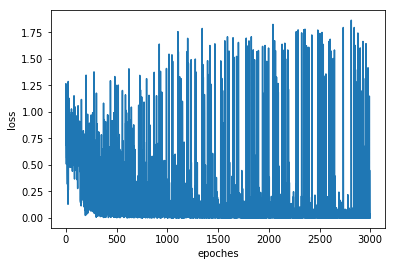

In [135]:
losses = np.array(bp_neru.losses)
losses = losses.reshape((3000,1))
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)),losses)
plt.xlabel('epoches')
plt.ylabel('loss')
plt.show()

In [142]:
import random
list1 = list(range(10))
list2=random.sample(list1, 3)
print(random.sample(list1, 3)) 
X[:,list2]

[1, 6, 0]


array([[-2.4776119 ,  1.30147769,  0.19693998],
       [-0.12582032, -1.98719546, -0.4778608 ],
       [ 0.72482952, -0.60965297,  1.16674141],
       [ 1.53309103,  0.91065749, -0.12003031]])

In [2]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as pl

digits = load_digits()
print(digits.data.shape)
pl.imshow(digits.images[0])
pl.show()

(1797, 64)


<Figure size 640x480 with 1 Axes>

In [3]:
X=digits.data
y=digits.target
print(X.shape,y.shape)

(1797, 64) (1797,)


In [4]:
y=y.reshape([1797,1])

In [5]:
from sklearn.preprocessing import LabelBinarizer
y2=LabelBinarizer().fit_transform(y)
y2.shape

(1797, 10)

In [6]:
X -= X.min()
X /= X.max()

In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
X_train=X_train.T
y_train=y_train.T
X_test=X_test.T
y_test=y_test.T

In [9]:
X_train.shape,y_train.shape

((64, 1347), (10, 1347))

In [10]:
y2=y2.T 
X=X.T

In [11]:
X.shape,y2.shape

((64, 1797), (10, 1797))

In [13]:
bp_neru=neru_bp(archtecture=[64,100,10])
bp_neru.init_value()
#bp_neru.feedforward(X)
#bp_neru.feedforward_a

In [14]:
bp_neru.train(X_train,y_train)

In [15]:
bp_neru.evaluate(X_test,y_test,True)

(64, 450)
预测准确率为：91.555556 %


0.9155555555555556

In [62]:
print(bp_neru.losses)

[array([[4.80852304]]), array([[2.82684485]]), array([[1.91912488]]), array([[1.43922731]]), array([[1.32043291]]), array([[1.22287508]]), array([[0.82580737]]), array([[1.29733596]]), array([[1.16435516]]), array([[1.06062016]]), array([[1.00259863]]), array([[0.84122625]]), array([[1.23917679]]), array([[1.14016356]]), array([[0.76466075]]), array([[1.10135689]]), array([[0.52213215]]), array([[1.40976083]]), array([[1.14362262]]), array([[0.99782162]]), array([[1.03630371]]), array([[0.7650848]]), array([[0.33162077]]), array([[1.45025217]]), array([[1.10931404]]), array([[1.00515207]]), array([[1.10627397]]), array([[1.04059404]]), array([[0.68301197]]), array([[1.06322152]]), array([[1.22243649]]), array([[0.9994349]]), array([[0.7982962]]), array([[0.8903893]]), array([[1.21869416]]), array([[0.7647399]]), array([[1.24107643]]), array([[0.55345506]]), array([[1.16157476]]), array([[0.6110978]]), array([[0.26823538]]), array([[0.13369915]]), array([[1.38477133]]), array([[1.392530

In [16]:
losses = np.array(bp_neru.losses)
print(len(losses))

3000


In [17]:
losses = losses.reshape(3000,1)

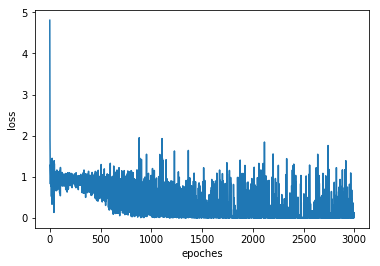

In [71]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)),losses)
plt.xlabel('epoches')
plt.ylabel('loss')
plt.show()